In [ ]:
!pip install healpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 44.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import healpy as hp
import matplotlib
from matplotlib import pyplot as plt

In [ ]:
# simulation data from DCC fits files
# og_df = pd.read_csv('simple_model_images_files_data.csv')

In [ ]:
def get_vertices(df, index):
    '''
    Function to convert ra and dec values into vectors compatible with healpy
    Arguments: The dataframe and the index value of the row corresponding to the SCA that will be plotted.
    Returns: An array of vertices in the form of vectors for each corner of the SCA.
    '''
    ra1 = df['RA1'][index]
    ra2 = df['RA2'][index]
    ra3 = df['RA3'][index]
    ra4 = df['RA4'][index]
    dec1 = df['DEC1'][index]
    dec2 = df['DEC2'][index]
    dec3 = df['DEC3'][index]
    dec4 = df['DEC4'][index]
    def ra_dec_to_theta_phi(ra, dec):
        ra_rad = np.radians(ra)
        dec_rad = np.radians(dec)
        theta = np.pi / 2 - dec_rad
        phi = ra_rad
        return theta, phi
    theta1, phi1 = ra_dec_to_theta_phi(ra1, dec1)
    theta2, phi2 = ra_dec_to_theta_phi(ra2, dec2)
    theta3, phi3 = ra_dec_to_theta_phi(ra3, dec3)
    theta4, phi4 = ra_dec_to_theta_phi(ra4, dec4)
    vec1 = hp.ang2vec(theta1, phi1)
    vec2 = hp.ang2vec(theta2, phi2)
    vec3 = hp.ang2vec(theta3, phi3)
    vec4 = hp.ang2vec(theta4, phi4)
    vertices = np.array([vec1, vec2, vec3, vec4])
    return vertices

In [ ]:
def translate_squares(df, shift=0.01, upward_repetitions=1, left_translation=True, downward_repetitions=1):
    """
    Function to create the tiling of the footprint, following the snake pattern outlined in (Wang et al., 2023). It works left to right if visualized using healpy gnomview().
    Arguments:
        df: Must be a dataframe that contains only one pointing (only 18 rows). Contains columns RA{i} and DEC{i} for the 4 corner coordinates of every SCA.
        shift: change this value to alter the spacing between rows of pointings. (Increase it and the space between decreases and vice versa.)
        upward_repetitions: One less than the number of desired rows
        left translation: True if another column is desired.
        downward_repetitions: One less than the number of desired rows
    Output: Original dataframe with the rows corresponding to the new pointings appended to the end.

    """
    # Step 1: Identify the bounding box
    single_pointing = df.tail(18)
    min_dec = single_pointing[['DEC1', 'DEC2', 'DEC3', 'DEC4']].min().min()
    max_dec = single_pointing[['DEC1', 'DEC2', 'DEC3', 'DEC4']].max().max()


    # Step 2: Calculate the upward translation distance
    translation_distance_up = max_dec - min_dec - shift

    # Initialize the result dataframe with the original data
    result_df = df.copy()

    # Step 3: Apply the upward translations
    for i in range(upward_repetitions):
        # Translate each corner's Dec coordinates upward
        translated_df = single_pointing.copy()
        translated_df[['DEC1', 'DEC2', 'DEC3', 'DEC4']] += (i + 1) * translation_distance_up

        # Append the translated squares to the result dataframe
        result_df = pd.concat([result_df, translated_df], ignore_index=True)

    if left_translation:
        # Step 4: Extract the last set of translated squares
        last_set = result_df.tail(18)

        # Step 5: Calculate the left translation distance
        min_ra = last_set[['RA1', 'RA2', 'RA3', 'RA4']].min().min()
        max_ra = last_set[['RA1', 'RA2', 'RA3', 'RA4']].max().max()
        translation_distance_left = max_ra - min_ra - shift

        # Step 6: Apply the left translation to the last set
        last_set_left_translated = last_set.copy()
        last_set_left_translated[['RA1', 'RA2', 'RA3', 'RA4']] += translation_distance_left

        # Append the left-translated squares to the result dataframe
        result_df = pd.concat([result_df, last_set_left_translated], ignore_index=True)

        # Step 7: Apply the downward translations to the left-translated set
        for i in range(downward_repetitions):
            downward_translated_df = last_set_left_translated.copy()
            downward_translated_df[['DEC1', 'DEC2', 'DEC3', 'DEC4']] -= (i + 1) * translation_distance_up
            result_df = pd.concat([result_df, downward_translated_df], ignore_index=True)

    return result_df

In [ ]:
def rotate_point(x, y, angle_rad):
    """Rotate a point clockwise by a given angle around the origin (0, 0)."""
    cos_angle = np.cos(angle_rad)
    sin_angle = np.sin(angle_rad)

    x_new = cos_angle * x + -sin_angle * y
    y_new = sin_angle * x + cos_angle * y

    return x_new, y_new

In [ ]:
def rotate_squares(df, foot_angle_deg):
    '''
    Function to rotate the footprint clockwise once as viewed in the gnomview projection.
    Commented out, there is code to also rotate individual pointings if desired. The angle of rotation and a list of lists of indices corresponding to the groups of SCAs in a pointing would need to be added as arguments in the function.
    The previous names for these arguments were point_angle_deg and subset_indices_list.
    Inputs:
        Dataframe that contains the rows for the footprint.
        foot_angle_deg is the rotation angle in degrees that you want to rotate the footprint by.
    Output: A dataframe of corner ra and dec coordinates for the rotated footprint. (If angle is 0 then it is the ra and dec coordinates for the original footprint).
    '''
    # Convert angles from degrees to radians
    angle_rad = np.radians(foot_angle_deg)
    #subset_angle_rad = np.radians(point_angle_deg)

    # Calculate the center of the entire set
    ra_center = df[[f'RA{i}' for i in range(1, 5)]].values.mean()
    dec_center = df[[f'DEC{i}' for i in range(1, 5)]].values.mean()

    # Initialize an empty DataFrame to store rotated squares
    rotated_data = {f'RA{i}': [] for i in range(1, 5)}
    rotated_data.update({f'DEC{i}': [] for i in range(1, 5)})

    # Apply the initial rotation to the entire set
    for index, row in (df.tail(648)).iterrows():
        for i in range(1, 5):
            ra, dec = row[f'RA{i}'], row[f'DEC{i}']

            # Translate points to origin (center of the entire set)
            ra_translated = ra - ra_center
            dec_translated = dec - dec_center

            # Rotate the points
            ra_rot, dec_rot = rotate_point(ra_translated, dec_translated, angle_rad)

            # Translate points back to the original position
            rotated_data[f'RA{i}'].append(ra_rot + ra_center)
            rotated_data[f'DEC{i}'].append(dec_rot + dec_center)

    # Create a DataFrame for the initially rotated squares
    rotated_df = pd.DataFrame(rotated_data)

    # Apply the additional rotation to each subset
    #for subset_indices in subset_indices_list:
     #   subset_df = rotated_df.iloc[subset_indices]
      #  ra_center_subset = subset_df[[f'RA{i}' for i in range(1, 5)]].values.mean()
       # dec_center_subset = subset_df[[f'DEC{i}' for i in range(1, 5)]].values.mean()

        #for index in subset_indices:
         #   row = rotated_df.loc[index]
          #  for i in range(1, 5):
           #     ra, dec = row[f'RA{i}'], row[f'DEC{i}']

                # Translate points to origin (center of the subset)
              #  ra_translated = ra - ra_center_subset
               # dec_translated = dec - dec_center_subset

                # Rotate the points
                #ra_rot, dec_rot = rotate_point(ra_translated, dec_translated, subset_angle_rad)

                # Translate points back to the original position
                #rotated_df.at[index, f'RA{i}'] = ra_rot + ra_center_subset
                #rotated_df.at[index, f'DEC{i}'] = dec_rot + dec_center_subset

    # Concatenate the original and rotated DataFrames
    #result_df = pd.concat([df, rotated_df], ignore_index=True)
    result_df = rotated_df

    return result_df

In [ ]:
def rotate_squares_custom(df, foot_angle_deg, ra_axis, dec_axis):
    '''
    Function to rotate the sky map clockwise around a user-specified axis.

    Args:
        df: DataFrame containing the rows for the footprint (RA/Dec corners).
        foot_angle_deg: Rotation angle in degrees (clockwise).
        ra_axis: RA of the rotation axis (custom).
        dec_axis: Dec of the rotation axis (custom).

    Returns:
        rotated_df: DataFrame with rotated RA and Dec coordinates.
    '''
    # Convert the rotation angle to radians
    angle_rad = np.radians(foot_angle_deg)

    # Initialize a DataFrame to store rotated coordinates
    rotated_data = {f'RA{i}': [] for i in range(1, 5)}
    rotated_data.update({f'DEC{i}': [] for i in range(1, 5)})

    # Apply rotation for each tile in the footprint
    for _, row in df.iterrows():
        for i in range(1, 5):  # Iterate over RA1, RA2, RA3, RA4 and their Dec counterparts
            ra, dec = row[f'RA{i}'], row[f'DEC{i}']

            # Translate points to the custom rotation axis
            ra_translated = ra - ra_axis
            dec_translated = dec - dec_axis

            # Rotate the points using the custom axis
            ra_rot, dec_rot = rotate_point(ra_translated, dec_translated, angle_rad)

            # Translate points back to the original position
            rotated_data[f'RA{i}'].append(ra_rot + ra_axis)
            rotated_data[f'DEC{i}'].append(dec_rot + dec_axis)

    # Create and return the rotated DataFrame
    rotated_df = pd.DataFrame(rotated_data)
    return rotated_df


In [ ]:
def calculate_coverage(df, total_degrees=365):
    """
    Calculates the effectiveness of sky coverage after each degree rotation and overall.

    Returns:
        coverage_per_rotation: List of effectiveness (fraction of original area covered) at each degree.
        overall_coverage: Average effectiveness over the year.
    """
    #Fetch pixels for the original region
    original_pixels = set()
    for index in df.index:
        vertices = get_vertices(df, index)  # Get the vertices for each region at t=0
        original_pixels.update(hp.query_polygon(NSIDE, vertices, inclusive=False))

    total_original_pixels = len(original_pixels)

    #Rotate the region and calculate coverage
    coverage_per_rotation = []
    for degree in range(total_degrees + 1):  # Include t=0
        # Rotate the region
        rotated_df = rotate_squares(df, degree)

        #Fetch pixels for rotated region
        rotated_pixels = set()
        for index in rotated_df.index:
            vertices = get_vertices(rotated_df, index)
            rotated_pixels.update(hp.query_polygon(NSIDE, vertices, inclusive=False))

        #Overlap calculation
        overlap_pixels = original_pixels & rotated_pixels  # Intersection of original and rotated
        coverage_fraction = len(overlap_pixels) / total_original_pixels


        coverage_per_rotation.append(coverage_fraction)

    #Overall coverage (mean) calculation
    overall_coverage = np.mean(coverage_per_rotation)

    return coverage_per_rotation, overall_coverage

In [ ]:
def visualize_effectiveness(effectiveness_per_rotation, overall_effectiveness):
    """
    For visualizing the efficiency (overlap) of sky coverage at various values of degree rotation.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(effectiveness_per_rotation)), effectiveness_per_rotation, label="Effectiveness per Rotation")
    plt.xlabel("Rotation (Degrees)")
    plt.ylabel("Effectiveness")
    plt.title("Effectiveness of Sky Coverage with Each Rotation")
    plt.ylim(0, 1.1)
    plt.legend()
    plt.grid()
    plt.show()

    print(f"Overall Effectiveness After 1 Year: {overall_effectiveness * 100:.2f}%")

In [ ]:
def create_trans_sq(og_df, data):
    """
    Utilised the code from earlier notebook to create the tiling strategy 8*5 = 40 exposures
    """
    up1, up2, up3, up4, up5 = data['up1'], data['up2'], data['up3'], data['up4'], data['up5']
    dw1, dw2, dw3, dw4, dw5 = data['dw1'], data['dw2'], data['dw3'], data['dw4'] ,data['up5']
    shift1, shift2, shift3, shift4, shift5 = data['shift1'], data['shift2'], data['shift3'], data['shift4'], data['shift5']
    left_tr1, left_tr2, left_tr3, left_tr4, left_tr5 = data['left_tr1'], data['left_tr2'], data['left_tr3'], data['left_tr4'], data['left_tr5']
    pointing_num = data['pointing_num']

    df = og_df[(og_df['POINTING'] == pointing_num)]

    #Finishes the first column and makes the second column
    trans = translate_squares(df, shift=shift1, upward_repetitions=up1, left_translation=left_tr1, downward_repetitions=dw1)
    #Starts the third column
    trans2 = translate_squares(trans, shift=shift2, upward_repetitions=up2, left_translation=left_tr2, downward_repetitions=dw2)
    #Finishes the third column and makes the fourth
    trans3 = translate_squares(trans2, shift=shift3, upward_repetitions=up3, left_translation=left_tr3, downward_repetitions=dw3)
    #Starts the fifth column
    trans4 = translate_squares(trans3, shift=shift4, upward_repetitions=up4, left_translation=left_tr4, downward_repetitions=dw4)
    #Finishes the fifth column
    new_df = translate_squares(trans4, shift=shift5, upward_repetitions=up5, left_translation=left_tr5, downward_repetitions=dw5)


    return new_df


In [ ]:
def create_trans_sq_customTest(og_df, data):
    """
    Utilised for testing purpose on a smaller region.
    """
    up1, up2, up3, up4, up5 = data['up1'], data['up2'], data['up3'], data['up4'], data['up5']
    dw1, dw2, dw3, dw4, dw5 = data['dw1'], data['dw2'], data['dw3'], data['dw4'] ,data['up5']
    shift1, shift2, shift3, shift4, shift5 = data['shift1'], data['shift2'], data['shift3'], data['shift4'], data['shift5']
    left_tr1, left_tr2, left_tr3, left_tr4, left_tr5 = data['left_tr1'], data['left_tr2'], data['left_tr3'], data['left_tr4'], data['left_tr5']
    pointing_num = data['pointing_num']

    df = og_df[(og_df['POINTING'] == pointing_num)]

    #Finishes the first column and makes the second column
    trans = translate_squares(df, shift=shift1, upward_repetitions=up1, left_translation=left_tr1, downward_repetitions=dw1)
    #Starts the third column
    # trans2 = translate_squares(trans, shift=shift2, upward_repetitions=up2, left_translation=left_tr2, downward_repetitions=dw2)
    # #Finishes the third column and makes the fourth
    # trans3 = translate_squares(trans2, shift=shift3, upward_repetitions=up3, left_translation=left_tr3, downward_repetitions=dw3)
    # #Starts the fifth column
    # trans4 = translate_squares(trans3, shift=shift4, upward_repetitions=up4, left_translation=left_tr4, downward_repetitions=dw4)
    # #Finishes the fifth column
    # new_df = translate_squares(trans4, shift=shift5, upward_repetitions=up5, left_translation=left_tr5, downward_repetitions=dw5)


    return trans


In [ ]:
def remove_edges(og_df, new_df, filter_val='K213', filter_pointing_num='K'):
    """
    Removing the corners to get the required 36 exposures.
    """
    filter_dict = {
        'R': [0, 7, 39, 32],
        'Z': [55, 62, 94, 87],
        'J': [165, 172, 204, 197],
        'H': [220, 227, 259, 252],
        'F': [275, 282, 314, 307],
        'K': [330, 337, 369, 362]
    }

    filter_vals = filter_dict[filter_pointing_num]

    filter_df = og_df[(og_df['FILTER'] == filter_val)]
    sorted_df = filter_df.sort_values(by='POINTING')

    ra1_array = new_df['RA1'].values
    ra2_array = new_df['RA2'].values
    ra3_array = new_df['RA3'].values
    ra4_array = new_df['RA4'].values
    dec1_array = new_df['DEC1'].values
    dec2_array = new_df['DEC2'].values
    dec3_array = new_df['DEC3'].values
    dec4_array = new_df['DEC1'].values

    SCA_array = new_df['SCA'].values
    filter_array = new_df['FILTER'].values
    exptime_array = new_df['EXPTIME'].values

    pointing_array = sorted_df['POINTING'].values
    mjd_array = sorted_df['MJD'].values
    dateobs_array = sorted_df['DATE-OBS'].values

    shape = SCA_array.shape[0]
    data = {
        'POINTING': pointing_array[:shape], #720
        'SCA': SCA_array,
        'FILTER': filter_array,
        'MJD': mjd_array[:shape],
        'EXPTIME': exptime_array,
        'DATE-OBS': dateobs_array[:shape],
        'RA1': ra1_array,
        'DEC1':dec1_array,
        'RA2': ra2_array,
        'DEC2': dec2_array,
        'RA3': ra3_array,
        'DEC3': dec3_array,
        'RA4': ra4_array,
        'DEC4': dec4_array
    }

    nuevo_df = pd.DataFrame(data)
    indices_to_drop = nuevo_df[nuevo_df['POINTING'] == filter_vals[0]].index
    nuevo_df.drop(indices_to_drop, inplace=True)


    indices_to_drop = nuevo_df[nuevo_df['POINTING'] == filter_vals[1]].index
    nuevo_df.drop(indices_to_drop, inplace=True)

    indices_to_drop = nuevo_df[nuevo_df['POINTING'] == filter_vals[2]].index
    nuevo_df.drop(indices_to_drop, inplace=True)

    indices_to_drop = nuevo_df[nuevo_df['POINTING'] == filter_vals[3]].index
    nuevo_df.drop(indices_to_drop, inplace=True)

    nuevo_df = nuevo_df.reset_index(drop=True)

    return nuevo_df

In [ ]:
def gen_tiling(og_df, data):
    '''
    Utilised the code from earlier notebook to create the tiling strategy 8*5 with corners removed = 36 exposures
    '''
    new_df = create_trans_sq(og_df, data)
    # new_df = create_trans_sq_customTest(og_df, data)
    final_df = remove_edges(og_df, new_df)

    return final_df

In [ ]:
def gen_tiling_customTest(og_df, data):
    '''
    Utilised the code from earlier notebook to create the tiling strategy 8*5 with corners removed = 36 exposures
    '''
    # new_df = create_trans_sq(og_df, data)
    new_df = create_trans_sq_customTest(og_df, data)
    final_df = remove_edges(og_df, new_df)

    return final_df

In [ ]:
def visualize(new_df):
    '''
    Visualzing the region via healpy
    '''
    obs_rows = new_df.index # new_df
    #iterates through the list of indices for all of the rows that correspond to the SCAs in the new footprint and gets the list of pixels that the SCAs touch.
    ipix_box_list = []
    for index in obs_rows:
        vertices = get_vertices(new_df, index)
        ipix_box_single = hp.query_polygon(nside=NSIDE, vertices=vertices, inclusive=False)
        ipix_box_list.append(ipix_box_single)
    ipix_box = np.concatenate(ipix_box_list)
    # rot = [9.7, -44] #The point we want our image to be centered on. Not the exact center of the footprint because this is just for visualization.
    mean_ra = new_df[['RA1', 'RA2', 'RA3', 'RA4']].mean().mean()
    mean_dec = new_df[['DEC1', 'DEC2', 'DEC3', 'DEC4']].mean().mean()
    rot = [mean_ra, mean_dec]
    m = np.zeros(hp.nside2npix(NSIDE)) #these 3 rows create the map that gets fed into healpy
    counts = np.bincount(ipix_box, minlength=len(m))
    m[:len(counts)] = counts
    hp.gnomview(m, rot=rot,title="Sky Location of Roman Pictures-Z087", reso = 1.6, xsize = 200) #plots the map centered on "rot". reso is the number of arcminutes per pixel and xsize is the number of pixels.
    plt.show()


In [ ]:
#Initializing all the variables.

data = {
    'up1':7,
    'dw1':7,
    'up2':0,
    'dw2':0,
    'up3':7,
    'dw3':7,
    'up4':0,
    'dw4':0,
    'up5':7,
    'dw5':0,
    'left_tr1':True,
    'left_tr2':True,
    'left_tr3':True,
    'left_tr4':True,
    'left_tr5': False,
    'shift1': 0.01,
    'shift2': 0.01,
    'shift3': 0.01,
    'shift4': 0.01,
    'shift5': 0.01,
    'pointing_num':330
}
NSIDE = 4096
NPIX  = hp.nside2npix(NSIDE)

og_df = pd.read_csv('simple_model_images_files_data.csv')

In [ ]:
new_df = gen_tiling(og_df, data)

astroPy -
rotation axis;
degree of rotation every 5 degrees


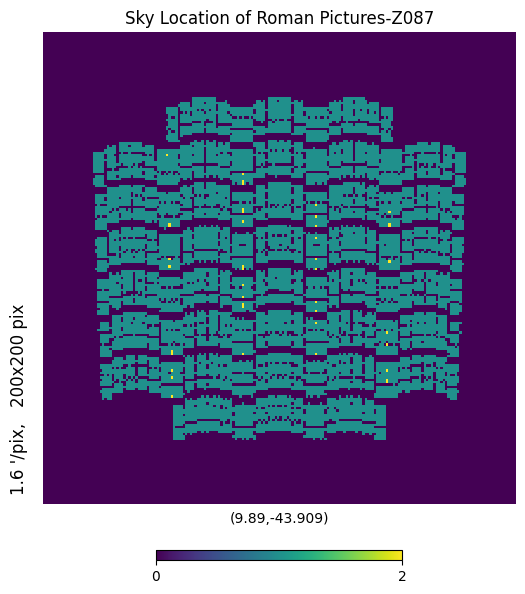

In [ ]:
visualize(new_df)

In [ ]:
ra_center = new_df[[f'RA{i}' for i in range(1, 5)]].max().max()
dec_center = new_df[[f'DEC{i}' for i in range(1, 5)]].mean().mean()
print(f"RA: {ra_center}; DEC: {dec_center}")

RA: 12.750262742838448; DEC: -43.90936239357259


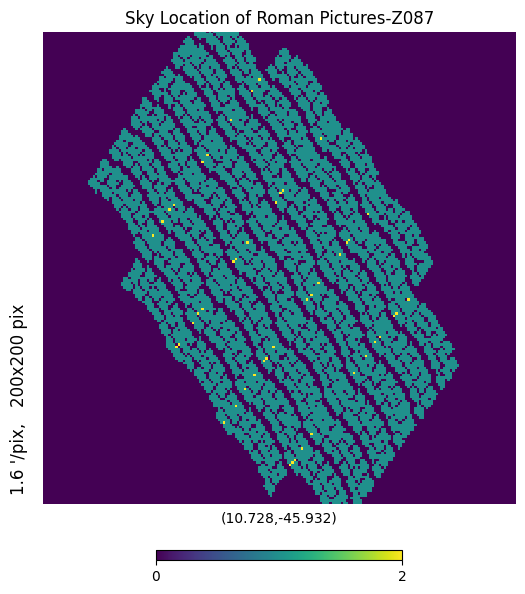

In [ ]:
#Rotating it by arbitrary value (theta) for visualization.

# result_df = rotate_squares(new_df, 200)
result_df = rotate_squares_custom(new_df, 45, ra_center, dec_center)
visualize(result_df)

In [ ]:
#Calculating the effectiveness.

effectiveness_per_rotation, overall_effectiveness = calculate_coverage(new_df, total_degrees=365)

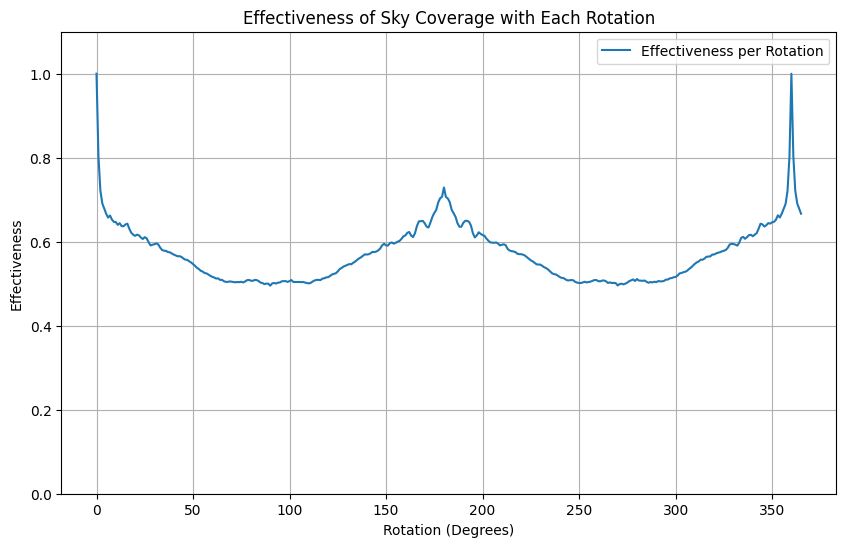

Overall Effectiveness After 1 Year: 57.07%


In [ ]:
#For visualizing the efficiency (overlap) at various values of theta

visualize_effectiveness(effectiveness_per_rotation, overall_effectiveness)

For single tile (1x1).

In [ ]:
test_data = {
    'up1':0,
    'dw1':0,
    'up2':0,
    'dw2':0,
    'up3':0,
    'dw3':0,
    'up4':0,
    'dw4':0,
    'up5':0,
    'dw5':0,
    'left_tr1':True,
    'left_tr2':True,
    'left_tr3':True,
    'left_tr4':True,
    'left_tr5': False,
    'shift1': 0.01,
    'shift2': 0.01,
    'shift3': 0.01,
    'shift4': 0.01,
    'shift5': 0.01,
    'pointing_num':330
}

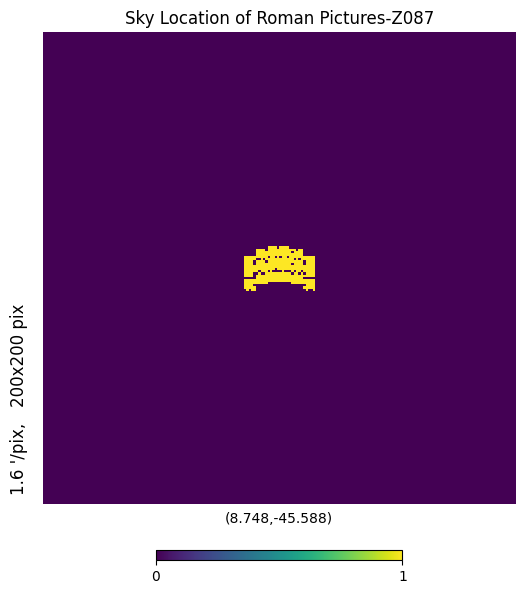

In [ ]:
test_df = gen_tiling_customTest(og_df, test_data)
visualize(test_df)

In [ ]:
test_df.columns

Index(['POINTING', 'SCA', 'FILTER', 'MJD', 'EXPTIME', 'DATE-OBS', 'RA1',
       'DEC1', 'RA2', 'DEC2', 'RA3', 'DEC3', 'RA4', 'DEC4'],
      dtype='object')

In [ ]:
test_df[[f'RA{i}' for i in range(1, 5)]].max().max()

9.323635496325133

In [ ]:
ra_center = test_df[[f'RA{i}' for i in range(1, 5)]].mean().mean()
dec_center = test_df[[f'DEC{i}' for i in range(1, 5)]].max().max()
print(f"RA: {ra_center}; DEC: {dec_center}")

RA: 8.74754906855745; DEC: -45.35369559066006


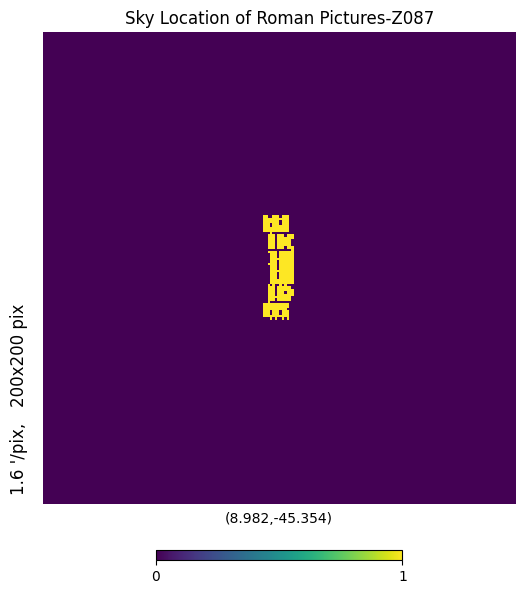

In [ ]:
#Rotating it by arbitrary value (theta) for visualization.

# resultTest_df = rotate_squares(test_df, 45)
# custom_ra = 0.0  # Example RA for the axis
# custom_dec = 0.0  # Example Dec for the axis
# resultTest_df = custom_rotate_squares(test_df, 180, ra_axis=custom_ra, dec_axis=custom_dec, axis='y')
resultTest_df = rotate_squares_custom(test_df, 90, ra_center, dec_center)
visualize(resultTest_df)

In [ ]:
#Calculating the effectiveness.

effectiveness_per_rotation_test, overall_effectiveness_test = calculate_coverage(test_df, total_degrees=365)

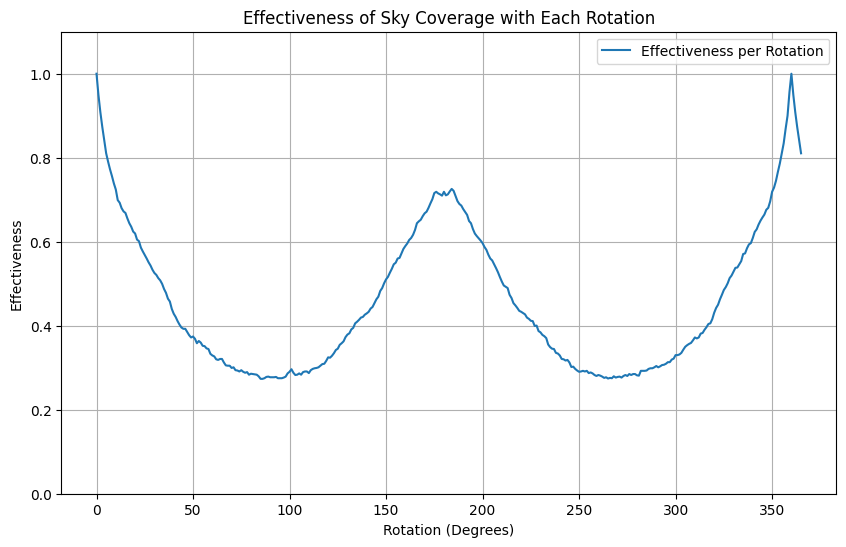

Overall Effectiveness After 1 Year: 46.04%


In [ ]:
#For visualizing the efficiency (overlap) at various values of theta

visualize_effectiveness(effectiveness_per_rotation_test, overall_effectiveness_test)

For two tiles (2x1)

In [ ]:
test_data2 = {
    'up1':0,
    'dw1':1,
    'up2':0,
    'dw2':0,
    'up3':0,
    'dw3':0,
    'up4':0,
    'dw4':0,
    'up5':0,
    'dw5':0,
    'left_tr1':True,
    'left_tr2':True,
    'left_tr3':True,
    'left_tr4':True,
    'left_tr5': False,
    'shift1': 0.01,
    'shift2': 0.01,
    'shift3': 0.01,
    'shift4': 0.01,
    'shift5': 0.01,
    'pointing_num':330
}

In [ ]:
test_df2 = gen_tiling_customTest(og_df, test_data2)
visualize(test_df2)

NameError: name 'test_data2' is not defined

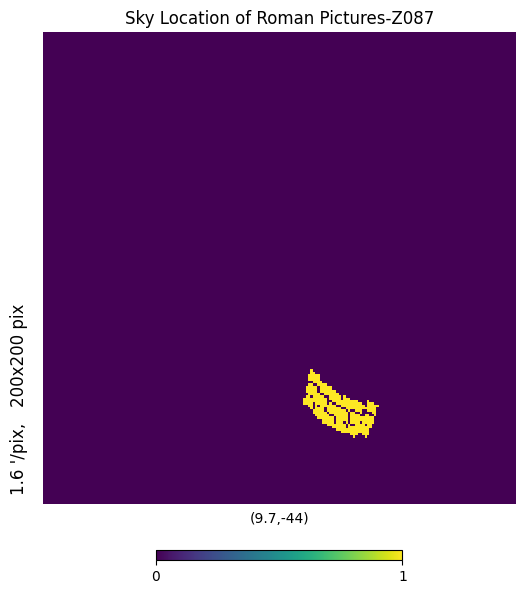

In [ ]:
#Rotating it by arbitrary value (theta) for visualization.

resultTest_df2 = rotate_squares(test_df2, 200)
visualize(resultTest_df)

In [ ]:
#Calculating the effectiveness.

effectiveness_per_rotation_test2, overall_effectiveness_test2 = calculate_coverage(test_df2, total_degrees=365)

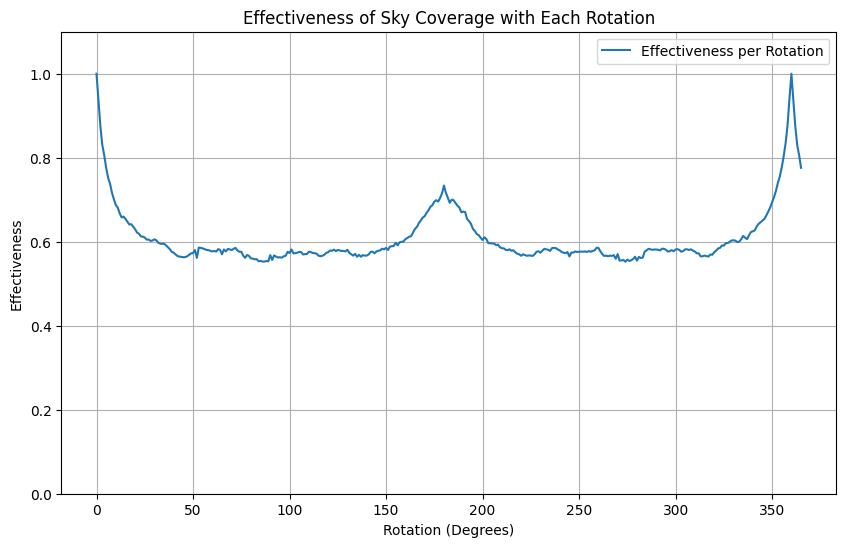

Overall Effectiveness After 1 Year: 60.85%


In [ ]:
#For visualizing the efficiency (overlap) at various values of theta

visualize_effectiveness(effectiveness_per_rotation_test2, overall_effectiveness_test2)

In [ ]:
def create_centered_tile(og_df, pointing_num):
    """
    Generate a single centered tile by explicitly centering it on the RA-Dec midpoint.
    """
    # Step 1: Extract the pointing rows
    df = og_df[og_df['POINTING'] == pointing_num]

    # Step 2: Calculate the center RA and Dec of the original tile
    center_ra = df[['RA1', 'RA2', 'RA3', 'RA4']].mean().mean()
    center_dec = df[['DEC1', 'DEC2', 'DEC3', 'DEC4']].mean().mean()

    # Step 3: Translate the tile to center it at (0, 0) for visualization
    df_centered = df.copy()
    for i in range(1, 5):  # For RA1, RA2, RA3, RA4 and DEC1, DEC2, DEC3, DEC4
        df_centered[f'RA{i}'] = df[f'RA{i}'] - center_ra
        df_centered[f'DEC{i}'] = df[f'DEC{i}'] - center_dec

    return df_centered


def gen_centered_tile(og_df, pointing_num):
    """
    Generate and return a single centered tile.
    """
    centered_df = create_centered_tile(og_df, pointing_num)
    return centered_df


In [ ]:
centered_df.head()

,POINTING,SCA,FILTER,MJD,EXPTIME,DATE-OBS,RA1,DEC1,RA2,DEC2,RA3,DEC3,RA4,DEC4
492055,330,16.0,K213,62002.33849,901.175,2028-08-19 08:07:25.536000,-0.576123,-0.255460,-0.572572,-0.132265,-0.395814,-0.131784,-0.398974,-0.254985
492056,330,12.0,K213,62002.33849,901.175,2028-08-19 08:07:25.536000,-0.008718,0.234087,-0.009432,0.117205,-0.184647,0.116766,-0.183570,0.233647
492057,330,5.0,K213,62002.33849,901.175,2028-08-19 08:07:25.536000,0.203993,-0.041539,0.201526,0.078607,0.377651,0.077766,0.380496,-0.042375
492058,330,4.0,K213,62002.33849,901.175,2028-08-19 08:07:25.536000,0.203729,-0.189741,0.201559,-0.067049,0.379435,-0.067425,0.381996,-0.190113
492059,330,2.0,K213,62002.33849,901.175,2028-08-19 08:07:25.536000,0.008598,-0.015067,0.008191,0.104800,0.184977,0.104240,0.185762,-0.015627


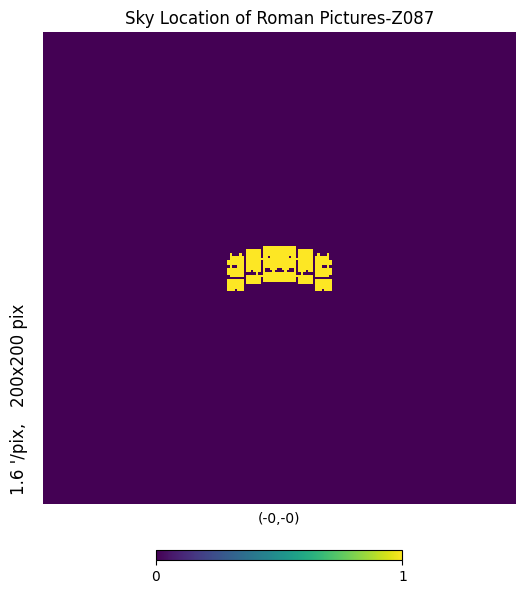

In [ ]:
# Parameters
pointing_num = 330  # Replace with the desired pointing ID

# Generate centered tile
centered_df = gen_centered_tile(og_df, pointing_num)

# Visualize the centered tile
visualize(centered_df)


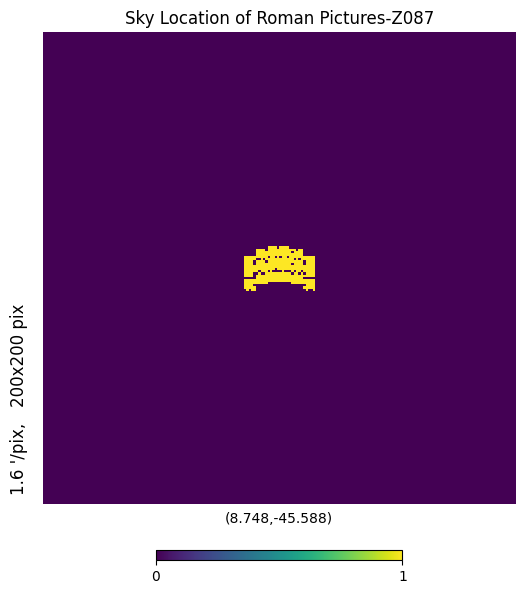

In [ ]:
visualize(test_df)

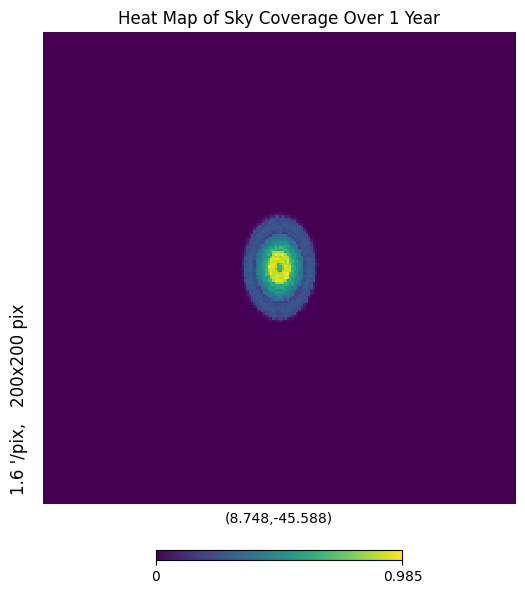

In [ ]:
def create_heat_map(df, NSIDE=128, total_degrees=365, step=5):
    """
    Creates a heat map showing pixel retention over a time period (rotations every step degrees).

    Args:
        df: DataFrame containing RA and Dec for the original region.
        NSIDE: HEALPix resolution.
        total_degrees: Total degrees of rotation (default: 365).
        step: Step size for degrees (default: 5).

    Returns:
        heat_map: HEALPix map with pixel frequencies.
    """
    total_steps = total_degrees // step + 1  # Total number of rotations
    heat_map = np.zeros(hp.nside2npix(NSIDE))  # Initialize HEALPix map

    # Iterate through rotations
    for degree in range(0, total_degrees + 1, step):
        # Rotate the region
        rotated_df = rotate_squares(df, degree)

        # Fetch pixels for the rotated region and update the heat map
        for index in rotated_df.index:
            vertices = get_vertices(rotated_df, index)
            pixels = hp.query_polygon(NSIDE, vertices, inclusive=False)
            heat_map[pixels] += 1  # Increment pixel counts

    # Normalize or clip values for visualization (optional)
    heat_map /= heat_map.max()  # Normalize to 0–1 range

    # Display the heat map using gnomview
    rot = [8.748, -45.588]  # Center the map at (RA=0, Dec=0) or adjust dynamically
    hp.gnomview(heat_map, rot=rot, title="Heat Map of Sky Coverage Over 1 Year", reso=1.6, xsize=200, cmap='viridis')
    plt.show()

    return heat_map

# Usage
heat_map = create_heat_map(test_df, NSIDE=4096, total_degrees=365, step=5)


In [ ]:
def calculate_pixel_efficiency(df, NSIDE=128, total_degrees=365, step=5):
    """
    Calculates pixel efficiency and records the degrees where each pixel appears.

    Args:
        df: DataFrame containing RA and Dec for the original region.
        NSIDE: HEALPix resolution.
        total_degrees: Total degrees of rotation (default: 365).
        step: Step size for degrees (default: 5).

    Returns:
        pixel_data: Dictionary containing efficiency and appearance degrees for each pixel.
    """
    total_steps = total_degrees // step + 1  # Total rotations
    pixel_data = {}  # Store pixel appearances

    # Iterate through rotations
    for degree in range(0, total_degrees + 1, step):
        # Rotate the region
        rotated_df = rotate_squares(df, degree)

        # Fetch pixels for the rotated region
        for index in rotated_df.index:
            vertices = get_vertices(rotated_df, index)
            pixels = hp.query_polygon(NSIDE, vertices, inclusive=False)

            for pixel in pixels:
                if pixel not in pixel_data:
                    pixel_data[pixel] = {"appearances": 0, "degrees": []}
                pixel_data[pixel]["appearances"] += 1
                pixel_data[pixel]["degrees"].append(degree)

    # Calculate efficiency
    for pixel, data in pixel_data.items():
        data["efficiency"] = data["appearances"] / total_steps

    return pixel_data

# Usage
pixel_details = calculate_pixel_efficiency(test_df, NSIDE=4096, total_degrees=365, step=5)

# Example: Print efficiency and appearance details for the first few pixels
max_val = 0
pix = -1
for pixel, details in list(pixel_details.items())[:]:
    if details['efficiency'] > max_val:
        max_val = details['efficiency']
        pix = pixel
    # print(f"Pixel {pixel}: Efficiency = {details['efficiency']:.2f}, Degrees = {details['degrees']}")

print(f"Max Efficiency for pixel: {pix} is: {max_val}")

Max Efficiency for pixel: 172757720 is: 0.918918918918919
